# Single-cell ATAC-seq Module 4

## Overview
This tutorial demonstrates the principle behind the analysis of spatially resolvable single-cell ATACseq data. The transposase-accessible chromatin using sequencing (ATAC-seq) assay has been widely adopted since its development by Jason Buenrostro and colleagues in the Greenleaf lab in 2013, and it’s now one of the most popular approaches to investigate chromatin openness and its dynamics.

ATAC-seq is used to identify regions of the genome that have open chromatin states that are generally associated with sites undergoing active transcription. Transcription factor binding sites and positions of nucleosomes can also be identified from the analysis of ATAC-seq data, potentially allowing important genetic pathways in the samples to be elucidated.

The below graphic shows an overview of a typical ATAC sequencing experiment. These series of steps allow for discovery of chromatin accessibility dynamics. The flow displayed is: Batch correction -> Data transformation -> Dimension reduction -> Clustering -> Cell identity annotation.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2001037020303019-gr1.jpg" alt="Drawing" style="width:1000px;"/>

The above image is obtained from: Seungbyn Baek, Insuk Lee, Single-cell ATAC sequencing analysis: From data preprocessing to hypothesis generation, Computational and Structural Biotechnology Journal, Volume 18, 2020, Pages 1429-1439, ISSN 2001-0370,
https://doi.org/10.1016/j.csbj.2020.06.012. PMID: [32637041](https://pubmed.ncbi.nlm.nih.gov/32637041/)

## Learning Objectives

* **Understand the single-cell ATAC-seq workflow:** From sample preparation and sequencing to data analysis and interpretation, including quality control, normalization, dimensionality reduction, clustering, and visualization.
* **Perform data preprocessing for single-cell ATAC-seq data:** Specifically, TF-IDF normalization and frequency-based peak selection.
* **Apply dimensionality reduction techniques:**  Using PCA, t-SNE, and UMAP to reduce the complexity of the data and visualize it in two dimensions.
* **Perform clustering analysis:** Employing Louvain and Leiden algorithms to group similar cells based on their chromatin accessibility profiles.
* **Visualize and interpret clustering results:**  Using UMAP and t-SNE plots colored by cluster assignments and known cell types to evaluate clustering performance.
* **Calculate and visualize gene activity scores:** Computing and visualizing gene activity scores based on nearby peaks for marker genes to investigate cell type-specific gene regulation.
* **Identify differential peaks:**  Using logistic regression to find peaks that are differentially accessible between clusters, which can reveal insights into gene regulatory mechanisms driving cell-type differences.
* **Utilize GPU acceleration for single-cell analysis:** Learn how to use RAPIDS to speed up computationally intensive tasks in single-cell ATAC-seq analysis.
* **Work with single-cell genomics data formats and tools:** Gain familiarity with the .h5ad file format, the `anndata` and `scanpy` libraries, and other relevant tools for single-cell analysis.
* **Interpret the results of single-cell ATAC-seq analysis:** Relate the computational findings to biological insights about cell types, gene regulation, and potential functional differences between cell populations.  This includes comparing the results with existing annotations and validating findings with marker gene analysis.

## Prerequisites:

**Software and Libraries:**

* **jupyterquiz:** For interactive quizzes within the notebook.
* **jupytercards:** For flashcards within the notebook.
* **AWS CLI:** For interacting with Amazon S3 bucket via the command line (used to copy data from the bucket).
* **NumPy:** For numerical operations.
* **Scanpy:**  A Python library for single-cell analysis.
* **AnnData:**  For handling single-cell data.
* **Matplotlib:** For data visualization.
* **RAPIDS libraries (rmm, cuDF, cuPy, cuML):**  These are GPU-accelerated libraries for data science.  Critically, they require a suitable GPU-enabled environment to function.
* **wget:**  For downloading files from the internet (though its use seems removed in later edits).
* **utils:** A custom utility script provided within the "Tutorial4" directory.
* **rapids_scanpy_funcs:** A custom script with RAPIDS-accelerated functions, also provided within the "Tutorial4" directory.

**APIs:**

* **Amazon S3 API:**  The notebook uses `aws s3` to interact with an Amazon S3 bucket to copy example data files (`aws s3 cp`). This requires that the appropriate AWS services are enabled in your AWS account.

## Get Started
### Standard single-cell ATAC-seq workflow
The steps below encompass the standard preprocessing workflow. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features. 

The image below illustrates steps in a single-cell ATAC-Seq analysis workflow. Different from bulk tissue ATAC-Seq, single-cell ATAC-Seq can differentiate chromatin accessibility patterns in specific cell types. Firstly, reads are processed for quality control including steps such as demultiplexing, read alignment filtering, and duplicate removal. Normalization and dimensionality reduction are applied to address differences in sequencing depths and to get rid of the noise before clustering. After clusters are annotated, peak calling allows us to identify areas of the genome enriched for reads. This step is key to the overall goal of ATAC-Seq, identifying regions of accessible chromatin. Finally, we identify the differences in peaks among conditions in each cell cluster. Motif analysis allows for transcription factor discovery for the differentially enriched regions. 

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-021-21583-9/MediaObjects/41467_2021_21583_Fig1_HTML.png?as=webp" alt="Drawing" style="width:1000px;"/>

The above image was obtained from the following paper: Fang, R., Preissl, S., Li, Y. et al. Comprehensive analysis of single-cell ATAC-seq data with SnapATAC. Nat Commun 12, 1337 (2021). https://doi.org/10.1038/s41467-021-21583-9.
PMID [33637727](https://pubmed.ncbi.nlm.nih.gov/33637727/)

This tutorial will cover the following tasks. Prior to these steps, sample preparation, library construction and standard NGS short-read sequencing for massively parallel epigenomic profiling of thousands of individual cells will be performed.
- QC and selecting cells
- Normalization
- Identifying highly variable features
- Scaling the data
- Linear Dimensional reduction 
- Determining Dimensionality
- Clustering
- Assigning cell type identity to clusters
- Detecting spatially variable features
- Interactive visualization
- Integration with single-cell RNA-seq data

### Data and Analysis
The dataset we use here comes from Lareau et al., Nat Biotech 2019(PMID: [33637727](https://pubmed.ncbi.nlm.nih.gov/33637727/)), one of the highest throughput single-cell ATAC-seq experiments to date. They assay 136,000 resting and stimulated bone marrow-derived cells and study the different cell types and lineages that emerge. The paper analyzes resting and stimulated cells separately. We also find that these two populations split into largely distinct clusters, so here we only focus on the 60,000 resting cells from this experiment.

The cell metadata from this experiment includes annotated putative cell types based on chromVAR, Louvain clustering, and downstream cluster analysis. We compare our de novo identified clusters to these annotated clusters from the paper (and find good agreement).

The peak-cell matrix along with peak and cell metadata files are publicly available on GEO, [GSE123580](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123580). We processed the dataset to include only cells in the 'Resting' condition and peaks with nonzero coverage. In this tutorial, you will download (1) the processed peak-cell count matrix for this dataset (.h5ad), (2) the set of nonzero peak names (.npy), and (3) the cell metadata (.csv) from a bucket. In addition, there are 2 custom function files that need to be imported for the notebook to execute properly: 1) [rapids_scanpy_funcs.py](Tutorial4/rapids_scanpy_funcs.py) and 2) [utils.py](Tutorial4/utils.py). 

#### GPU Acceleration

Single-cell analysis is complex and compute intensive leading to long analysis times on an average HPC. Using GPUs speeds up the analysis. We will use a notebook instance that has the necessary Nvidia GPU drivers installed. Then, we will install the prerequisite software. The details are highlighted in the [README](README.md) of this module. 

This tutorial was adapted from the following NVIDIA GitHub repository (https://github.com/NVIDIA-Genomics-Research/rapids-single-cell-examples/blob/master/README.md). Follow the provided GitHub link to view acceleration and cost statistics from runs by the NVIDIA research team from December of 2020. 

### Take quiz - 1

In [ ]:
! pip install jupyterquiz jupytercards >> Tutorial4/logs.txt

In [2]:
import jupyterquiz
from jupyterquiz import display_quiz
display_quiz("../quiz_files/Quiz-1.json")

<IPython.core.display.Javascript object>

### Import Sample Files
Now lets create some folders to stay organized and copy over our prepared raw files. We're going to create a directory called "Tutorial4" which we'll use for this module. We'll then create sub-folders for our input files and for the files that we'll be creating during this module.

The following files will be downloaded when you execute the below command
- processed peak-cell count matrix for this dataset (.h5ad)
- set of nonzero peak names (.npy)
- cell metadata (.csv)
are stored inside the data folder

In [ ]:
# These commands create our directory structure.
#!cd $HOMEDIR
! mkdir -p Tutorial4/InputFiles
#!echo $PWD

# These commands help identify the Amazon S3 bucket where the example files are held.
original_bucket = "s3://nigms-sandbox/unmc_atac_data_examples/Tutorial4"

# This command copies our example files to the Tutorial4/InputFiles folder that we created above.
! aws s3 cp $original_bucket/dsci_resting_cell_metadata.csv Tutorial4/InputFiles
! aws s3 cp $original_bucket/dsci_resting_nonzeropeaks.h5ad Tutorial4/InputFiles
! aws s3 cp $original_bucket/dsci_resting_peaknames_nonzero.npy Tutorial4/InputFiles

The Hierarchical Data Format version 5 (H5AD/HDF5), is an open source file format that supports large, complex, heterogeneous data. Cell Ranger (a set of analysis pipelines) generates this output file with per-molecule information in HDF5 format.

### Let's make sure that the files copied correctly. 
#### You should see three files after running the following command:

In [3]:
! ls Tutorial4/InputFiles

dsci_resting_cell_metadata.csv	dsci_resting_peaknames_nonzero.npy
dsci_resting_nonzeropeaks.h5ad


### Installing required packages

In [ ]:
! mamba install -c bioconda scanpy anndata rmm cupy rapids -y >> Tutorial4/logs.txt

In [ ]:
! conda install -c rapidsai -c nvidia -c conda-forge cudf cugraph  -y >> Tutorial4/logs.txt

In [ ]:
import cudf
print(cudf.__version__)

In [ ]:
! pip install --upgrade scanpy matplotlib  >> Tutorial4/logs.txt

In [ ]:
! conda install cuml -y >> Tutorial4/logs.txt

In [ ]:
! conda update -c rapidsai -c conda-forge cuml >> Tutorial4/logs.txt

In [ ]:
! conda install -c conda-forge dask dask-cudf cuml >> Tutorial4/logs.txt

#### Restart Kernel at this point

In [4]:
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict
import time
import os
import rmm
import cudf
import cupy as cp
from cuml.decomposition import PCA
from cuml.manifold import TSNE
import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

In [5]:
#installing custom python functions by nvidia research team 
import Tutorial4.rapids_scanpy_funcs as rapids_scanpy_funcs
import Tutorial4.utils as utils

In [6]:
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

# cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

### STEP 2: Setting Up Parameters

### In the below set of parameters, you will begin defining each constant to enable successful calling of peaks.

In [7]:
# Filtering peaks
n_top_peaks = 5000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

In [8]:
start_time = time.time()

### Input data

In the cell below, we provide the path to the sparse .h5ad file containing the peak x cell count matrix to analyze.

In [10]:
%%time
input_file = "Tutorial4/InputFiles/dsci_resting_nonzeropeaks.h5ad"

adata = anndata.read_h5ad(input_file)
adata_raw = adata.copy()
print(adata.X.shape)

(60495, 143691)
CPU times: user 262 ms, sys: 360 ms, total: 622 ms
Wall time: 621 ms


### Flash Card - 1: Learn the primary advantages of single cell ATAC-seq

In [11]:
import jupytercards
from jupytercards import display_flashcards
display_flashcards("../quiz_files/my_cards-1.json")

<IPython.core.display.Javascript object>

### STEP 3: Preprocessing

In [12]:
preprocessing_start = time.time()

### TF-IDF normalization

We use log1p(pseudocount / tf)*idf. It uses the raw binary count matrix as the TF matrix rather than dividing by the total reads per cell, which obviates the need for log scaling. The resulting TF-IDF transformed matrix will be used as input into PCA without any further normalization or scaling.

In [13]:
%%time

lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 1.89 s, sys: 768 ms, total: 2.65 s
Wall time: 2.65 s


### Frequency-based peak selection

We want to choose peaks that have highest discriminative power between cells. A good proxy for discriminative power is variance; since peak data (especially on a sparse dataset like this) is essentially binary, the highest variance peaks are the ones with closest to 50% representation across cells (p=1/2 maximizes Bernoulli variance). The most frequent peak in this dataset only has 33% representation, so in practice we just end up taking the top N most frequent peaks, where N is a parameter we set above (default 5000).

In [14]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

(60495, 5000)
CPU times: user 904 ms, sys: 132 ms, total: 1.04 s
Wall time: 1.04 s


In [15]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 7.37sec


### STEP 4: Clustering & Visualization

Clustering is the task of dividing the cells into a number of groups such that data points (open chromatin peaks) in the same groups are more similar to other data points in the same group and dissimilar to the data points in other groups.

### PCA

Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

In [16]:
%%time
adata = anndata.AnnData(X=adata.X.todense(),
                        obs=adata.obs,
                        var=adata.var)
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
adata.obsm["X_pca"].shape

CPU times: user 20.7 s, sys: 3.75 s, total: 24.5 s
Wall time: 24.4 s


(60495, 50)

### Flash Card - 2: Learn the benefits of single-cell ATAC-seq

In [17]:
import jupytercards
from jupytercards import display_flashcards
display_flashcards("../quiz_files/my_cards-2.json")

<IPython.core.display.Javascript object>

### UMAP visualization

Uniform Manifold Approximation and Projection (UMAP) is a dimensionality reduction technique that can be used for visualization similarly to t-SNE, but also for general non-linear dimension reduction.

UMAP algorithm is founded on three assumptions about the data:

1. The data is uniformly distributed on a Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected.

In [18]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 3.09 s, sys: 50.8 ms, total: 3.14 s
Wall time: 3.12 s


In [19]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

CPU times: user 720 ms, sys: 76.6 ms, total: 796 ms
Wall time: 811 ms


### Flash Card - 3: Understanding the benefits of single cell ATAC-seq compared to bulk ATAC-seq?

In [20]:
import jupytercards
from jupytercards import display_flashcards
display_flashcards("../quiz_files/my_cards-3.json")

<IPython.core.display.Javascript object>

### Graph clustering
Below, we show how to use the RAPIDS Louvain clustering or Leiden clustering functions to cluster the data.

In [21]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 690 ms, sys: 132 ms, total: 822 ms
Wall time: 821 ms


In [22]:
%%time
adata.obs['leiden'] = rapids_scanpy_funcs.leiden(adata)

CPU times: user 609 ms, sys: 108 ms, total: 717 ms
Wall time: 715 ms


Below, we plot the UMAP visualization of the cells colored by the Louvain clusters. Next, we color the cells using the cell type annotations reported in the source paper. We see that the clusters we discovered match closely with the reported cell types.

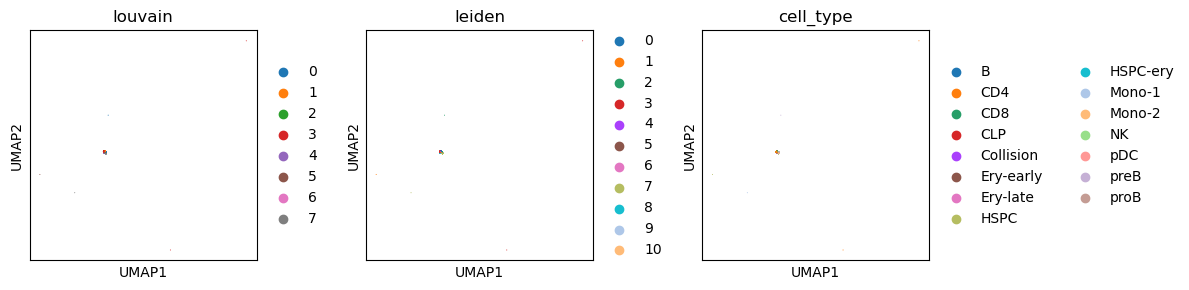

CPU times: user 1.73 s, sys: 7.56 ms, total: 1.73 s
Wall time: 1.73 s


In [23]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### Take quiz - 2

In [25]:
display_quiz("../quiz_files/Quiz-2.json")

<IPython.core.display.Javascript object>

### t-SNE visualization

T-distributed neighbor embedding (t-SNE) is a dimensionality reduction technique that helps visualize high-dimensional data sets. It takes the original data and matches both distributions to determine how to best represent this data using fewer dimensions.  

In [26]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:, :tsne_n_pcs])

[W] [20:28:04.689632] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 2.15 s, sys: 36.8 ms, total: 2.19 s
Wall time: 2.18 s


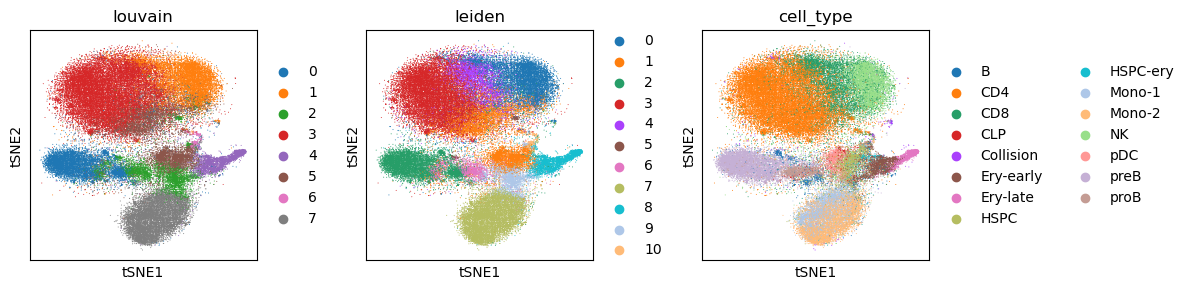

CPU times: user 1.82 s, sys: 7.8 ms, total: 1.82 s
Wall time: 1.82 s


In [27]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### Marker genes

We now compute a gene activity score representing the activity of each marker gene in each cell. We use the adata_raw object to compute this score. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [28]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 514 ms, sys: 239 μs, total: 515 ms
Wall time: 514 ms


In [29]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 762 ms, sys: 4.05 ms, total: 766 ms
Wall time: 765 ms


### Take quiz - 3

In [30]:
display_quiz("../quiz_files/Quiz-3.json")

<IPython.core.display.Javascript object>

We now visualize the UMAP plot colored by activity of marker genes. We observe that the activation of cell-type specific marker genes correlates well with the cell types identified by Louvain clustering.

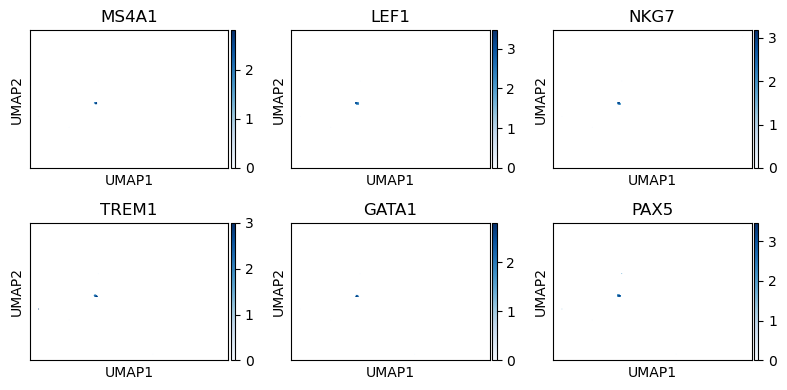

CPU times: user 1.98 s, sys: 7.91 ms, total: 1.99 s
Wall time: 1.99 s


In [31]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

### STEP 5: Finding differential peaks

### Find Differential peaks
We perform an accelerated logistic regression-based differential peak computation using RAPIDS.

In [32]:
import pandas

In [33]:
type(adata.obs["louvain"])

pandas.core.series.Series

In [34]:
print(adata.obs["louvain"].dtype)

category


In [35]:
adata.obs["louvain"]

Exp100-Sample9.all_Tn5-AAAGAA_BC00404_N03    5
Exp100-Sample9.all_Tn5-AAAGAA_BC00461_N02    5
Exp100-Sample9.all_Tn5-AAAGAA_BC00600_N02    5
Exp100-Sample9.all_Tn5-AAAGAA_BC00633_N02    0
Exp100-Sample9.all_Tn5-AAAGAA_BC00638_N03    7
                                            ..
Exp100-Sample1.all_Tn5-GTTTCA_BC04312_N05    7
Exp100-Sample1.all_Tn5-GTTTCA_BC04332_N04    3
Exp100-Sample1.all_Tn5-GTTTCA_BC04405_N01    5
Exp100-Sample1.all_Tn5-GTTTCA_BC04710_N02    5
Exp100-Sample1.all_Tn5-GTTTCA_BC05822_N04    7
Name: louvain, Length: 60495, dtype: category
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

In [36]:
for i in adata.obs["louvain"].cat.categories:
    print(i)

0
1
2
3
4
5
6
7


In [42]:
n_diff_peaks=8

In [43]:
%%time

cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat.categories).astype("category")




var_names = cudf.Series(adata.var_names)
dense_gpu_array = cp.sparse.csr_matrix(cp.array(adata.X))

scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    dense_gpu_array,
    cluster_labels, 
    var_names, 
    penalty='none',
    n_genes=n_diff_peaks, groups='all', reference='rest')

CPU times: user 1.5 s, sys: 156 ms, total: 1.66 s
Wall time: 1.65 s


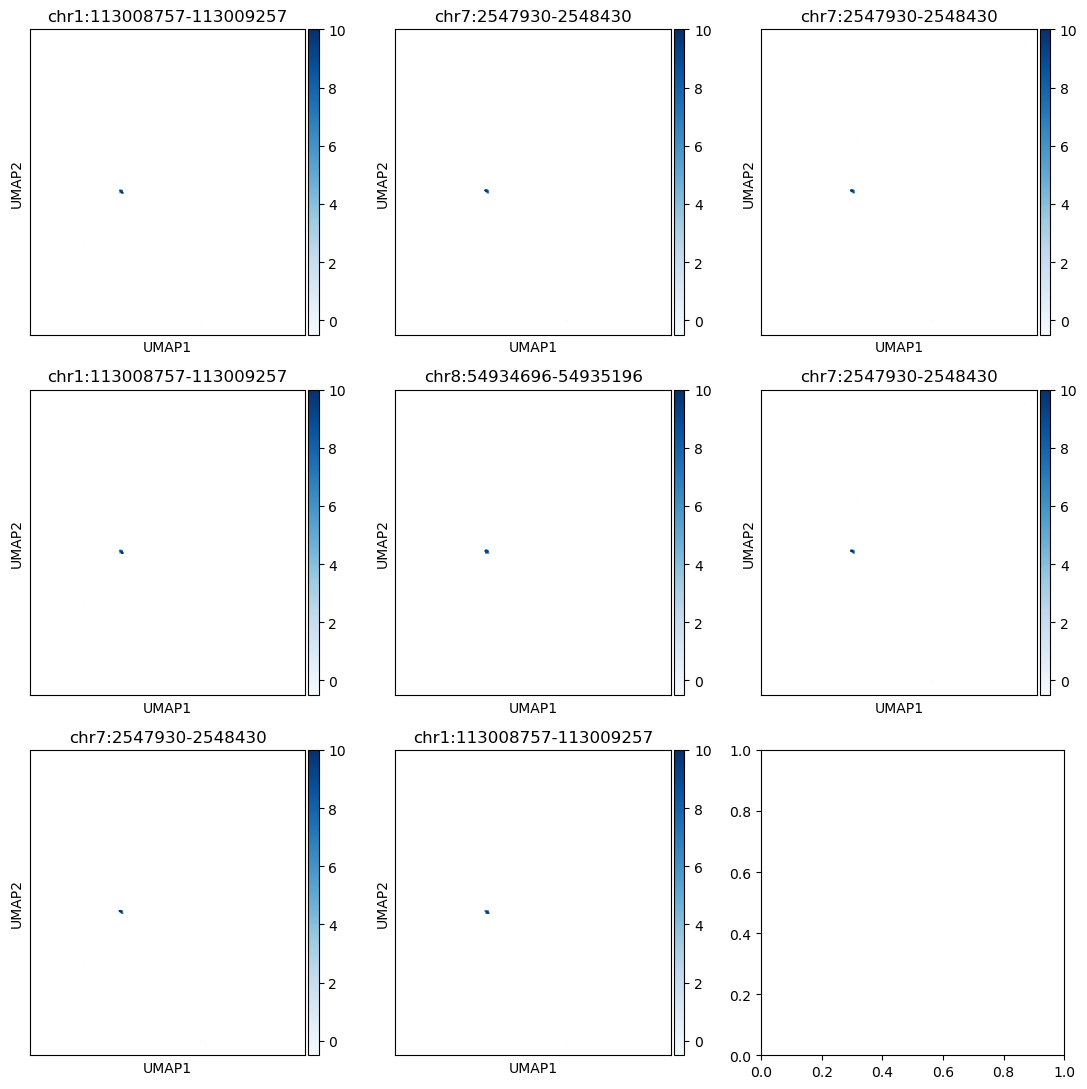

CPU times: user 3.1 s, sys: 15 ms, total: 3.11 s
Wall time: 3.11 s


In [44]:
%%time
fig, axs = plt.subplots(len(names[0])//3 + 1, 3, figsize=(11,11), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(names[0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=10, vmin=-0.5,
           cmap='Blues'
          )
plt.tight_layout()
plt.show()

In [45]:
print("Full time: %.2fsec" % (time.time() - start_time))

Full time: 385.41sec


### Congratulations! You have successfully completed the single-cell tutorial
You successfully performed peak-cell matrix, then perform peak selection, normalization, dimensionality reduction, clustering, and visualization on single cell ATAC-seq data. You also visualized regulatory activity at marker genes and computed differential peaks.

## Conclusion

This notebook demonstrated a typical workflow for analyzing single-cell ATAC-seq data using GPU acceleration. Starting with a preprocessed peak-cell count matrix from a bone marrow dataset, we performed TF-IDF normalization and selected the most frequent peaks.  Dimensionality reduction was achieved through PCA, followed by clustering using both Louvain and Leiden algorithms.  UMAP and t-SNE visualizations allowed for exploration of the cluster structures and their correlation with known cell types. We further validated these clusters by assessing the activity of marker genes, observing strong concordance between gene activity and assigned cell identities. Finally, we identified differentially accessible peaks between clusters using logistic regression. This comprehensive analysis pipeline allowed us to effectively characterize cell heterogeneity and identify key regulatory elements within the bone marrow sample.

## Clean Up

<div class="alert alert-block alert-danger">
    <b>&#128721; Caution:</b> Remember to stop your notebook instance after you are finished with your work in order to avoid incurring additional charges.
</div>